<a href="https://colab.research.google.com/github/kartik-kumarr/ScopusCrawler/blob/main/ScopusCrawler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Scopus crawler


In [ ]:
import os
import requests
import json
import matplotlib.pyplot as plt

from google.colab import userdata

apiKey = userdata.get('apiKey')
insttoken = userdata.get('insttoken')


In [ ]:
import requests
import time

url = 'https://api.elsevier.com/content/search/scopus'

headers = {
    'X-ELS-APIKey': apiKey,
    'X-ELS-Insttoken': insttoken
}

query = (
    '("awkward posture" OR "awkward pose" OR "awkward posture detection" OR '
    '"awkward pose classification" OR "posture analysis" OR "postural assessment") '
    'AND ("computer vision" OR "vision-based system" OR "pose estimation" OR '
    '"human pose estimation" OR "deep learning" OR "machine learning" OR '
    '"convolutional neural network" OR "transformer model") '
    'AND ("ergonomics" OR "occupational health" OR "workplace safety" OR '
    '"musculoskeletal disorder" OR "work-related musculoskeletal disorder") '
    'AND NOT ("animal model" OR "veterinary" OR "non-human" OR "robotic pose")'
)

all_results = []
unique_ids = set()
count = 25
total_results = 4000

for start in range(0, total_results, count):
    prevUn = len(all_results)
    params = {
        'query': query,
        'count': count,
        'start': start,
        'view': 'COMPLETE'
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Error at start={start}: {response.status_code}")
        break

    data = response.json()
    entries = data.get('search-results', {}).get('entry', [])

    for entry in entries:
        eid = entry.get('eid')
        if eid and eid not in unique_ids:
            unique_ids.add(eid)
            all_results.append(entry)

    currUn = len(all_results)
    print(f"Fetched {len(entries)} entries from start={start} | Unique total so far: {len(all_results)}")
    if prevUn==currUn:
      break

    time.sleep(1)

print(f"Total unique entries fetched: {len(all_results)}")


Fetched 25 entries from start=0 | Unique total so far: 25
Fetched 25 entries from start=25 | Unique total so far: 50
Fetched 25 entries from start=50 | Unique total so far: 75
Fetched 25 entries from start=75 | Unique total so far: 100
Fetched 25 entries from start=100 | Unique total so far: 125
Fetched 25 entries from start=125 | Unique total so far: 150
Fetched 25 entries from start=150 | Unique total so far: 175
Fetched 25 entries from start=175 | Unique total so far: 200
Fetched 25 entries from start=200 | Unique total so far: 225
Fetched 25 entries from start=225 | Unique total so far: 250
Fetched 25 entries from start=250 | Unique total so far: 275
Fetched 25 entries from start=275 | Unique total so far: 300
Fetched 25 entries from start=300 | Unique total so far: 325
Fetched 25 entries from start=325 | Unique total so far: 350
Fetched 25 entries from start=350 | Unique total so far: 375
Fetched 25 entries from start=375 | Unique total so far: 400
Fetched 25 entries from start=40

In [ ]:
data = all_results

for entry in data:
    print(f"Title: {entry.get('dc:title')}")
    print(f"Authors: {entry.get('dc:creator')}")
    print(f"Abstract: {entry.get('dc:description')}")
    keywords = entry.get('dc:keywords') or entry.get('dc:subject') or 'No Keywords'
    print(f"keywords:{keywords}")
    print("\n")

Title: Cubital tunnel syndrome: anatomy, pathology, and imaging
Authors: Hussein M.
Abstract: Cubital tunnel syndrome (CuTS) is the second most common peripheral neuropathy in the upper limb. It occurs due to ulnar nerve compression within the fibro-osseous cubital tunnel at the elbow joint. Although CuTS is typically diagnosed clinically and with electrodiagnostic studies, the importance of imaging in evaluating the condition is growing. Knowing the typical imaging findings of ulnar nerve entrapment is necessary for precise diagnosis and proper treatment. In this article, we focus on the clinical features, workup and complex imaging of the “anatomic” cubital tunnel and relevant pathological entities.
keywords:No Keywords


Title: Crack Inspection on a Mosque by using Visual Inspection Method
Authors: Mohamad N.A.E.
Abstract: One common issue that is often observed in old buildings is the presence of defects, such as cracks. The presence of this crack poses a potential threat to the sa

In [ ]:
from huggingface_hub import login


## Login to hugging face using the required token

HfToken = userdata.get('HF_TOKEN')


login(token=HfToken)

In [ ]:
from collections import Counter
import re
import matplotlib.pyplot as plt
sensor_variants = {
    "IMU": ["imu", "inertial measurement unit"],
    "ECG": ["ecg", "electrocardiogram"],
    "EEG": ["eeg", "electroencephalogram"],
    "EMG": ["emg", "electromyography"],
    "EDA": ["eda", "electrodermal activity"],
    "PPG": ["ppg", "photoplethysmography"],
    "GSR": ["gsr", "galvanic skin response"],
    "SpO2": ["spo2 sensor", "oxygen saturation sensor"],
    "ToF camera": ["tof camera", "time-of-flight camera"],
    "WiFi CSI": ["wifi csi", "channel state information"],
    "WiFi RSSI": ["wifi rssi", "received signal strength indicator"],
    "RFID": ["rfid", "radio-frequency identification"],
    "UWB": ["uwb", "ultra wideband"],
    "NFC": ["nfc", "near-field communication sensor"],
    "FSR": ["fsr", "force sensitive resistor"],
    "IMES": ["imes", "intramuscular electromyographic sensor"],
    "mmWave radar": ["mmwave radar", "millimeter wave radar"],


    "RGB camera": ["camera", "visual sensor", "rgb camera", "stereo camera", "multiple cameras"],
    "Depth camera": ["depth camera"],
    "Infrared camera": ["infrared camera"],
    "Thermal camera": ["thermal camera"],
    "RGB-D": ["Microsoft's kinect", "kinect", "rgb-d", "KinectV2"],

    "RADAR": ["radar", "doppler radar", "mmwave"]
}


variant_to_canonical = {}
for canonical, variants in sensor_variants.items():
    for variant in variants:
        variant_to_canonical[variant] = canonical

# print(variant_to_canonical)

sensor_counter = Counter()

## finding the matching sensors in the abstract
for entry in all_results:
    abstract = entry.get("dc:description", "").lower()
    for variant, canonical in variant_to_canonical.items():
        if re.search(rf"\b{re.escape(variant)}\b", abstract):
            sensor_counter[canonical] += 1


print("Sensor usage across all abstracts")
for sensor, count in sensor_counter.most_common():
    print(f"{sensor}: {count}")

Sensor usage across all abstracts
EEG: 160
RGB camera: 100
EMG: 70
IMU: 68
ECG: 46
EDA: 35
RGB-D: 20
GSR: 19
RADAR: 16
PPG: 16
Depth camera: 6
Infrared camera: 4
WiFi CSI: 2
RFID: 1
FSR: 1
WiFi RSSI: 1


In [ ]:
# print( sensor_counter)

<ipython-input-13-cb946a099921>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(sensors))


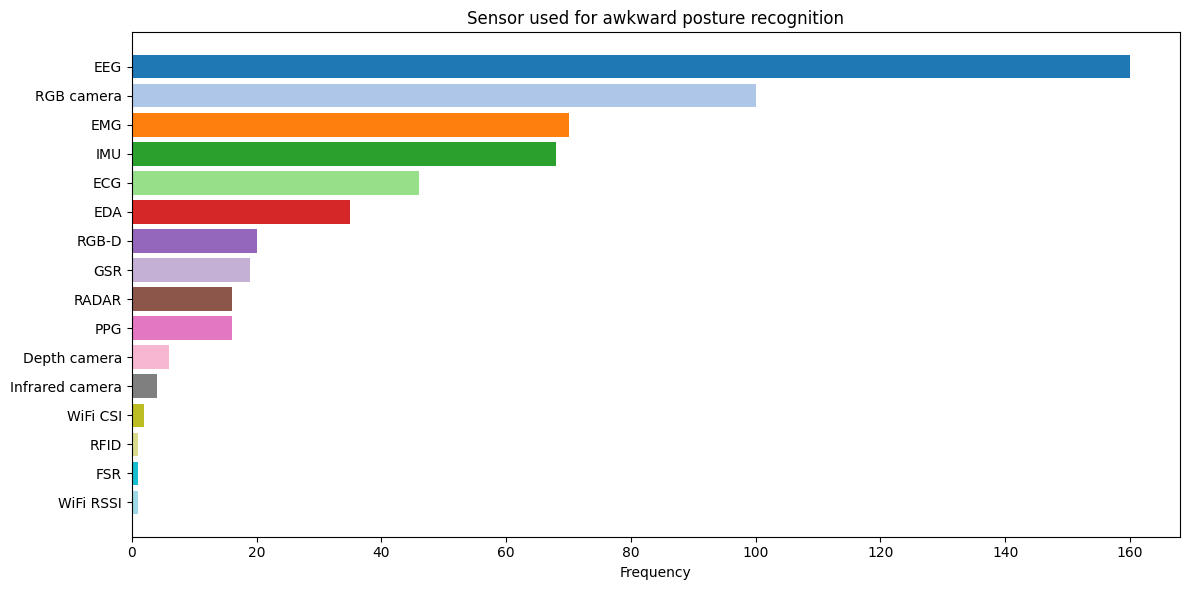

In [ ]:
sensors = [sensor for sensor, count in sensor_counter.most_common()]
counts = [count for sensor, count in sensor_counter.most_common()]


colors = plt.cm.get_cmap("tab20", len(sensors))

plt.figure(figsize=(12, 6))
plt.barh(sensors, counts, color=colors(range(len(sensors))))
plt.xlabel('Frequency')
plt.title('Sensor used for awkward posture recognition')
plt.gca().invert_yaxis()  # Most common sensor on top
plt.tight_layout()
plt.show()

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from torch.cuda.amp import autocast
from collections import Counter
import torch

# Initialize the sensor counter
sensor_counterLLM = Counter()

# Load model + tokenizer
model_name = "microsoft/Phi-3-mini-128k-instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Loop through all abstracts
for entry in tqdm(all_results, desc="Processing abstracts"):
    abstract = entry.get("dc:description", "").strip().lower()
    if not abstract:
        continue

    ## creating a prompt to extract relevant sensor names only
    prompt = f"Extract the primary sensors used only for awkward posture recognition that is mentioned in the following abstract:\n\n{abstract}\n\nOnly list the names of sensors. Note: only consider abstract in which research is related to awkward posture recognition."

    ## Direct tokenization and passing input to model
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    ## Reduced the number of output token to make the processing a bit faster
    with torch.no_grad(), autocast():
        generated_ids = model.generate(**inputs, max_new_tokens=30)

    ## Decoding the output
    output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    ## Check for sensor counts in the output
    for variant, canonical in variant_to_canonical.items():
        if re.search(rf"\b{re.escape(variant)}\b", output):
            sensor_counterLLM[canonical] += 1


config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Processing abstracts:   0%|          | 0/4000 [00:00<?, ?it/s]<ipython-input-14-dafb4199aa74>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():
Processing abstracts: 100%|██████████| 4000/4000 [1:16:07<00:00,  1.14s/it]


In [ ]:

# Print total counts for each sensor
print("Sensor usage across all abstracts:\n")
for sensor, count in sensor_counterLLM.most_common():
    print(f"{sensor}: {count}")

Sensor usage across all abstracts:

EEG: 160
RGB camera: 106
EMG: 71
IMU: 68
ECG: 46
EDA: 35
RGB-D: 20
GSR: 19
RADAR: 16
PPG: 16
Depth camera: 6
Infrared camera: 4
WiFi CSI: 2
RFID: 1
FSR: 1
WiFi RSSI: 1


<ipython-input-16-feb8d2fb4d8c>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(sensors))


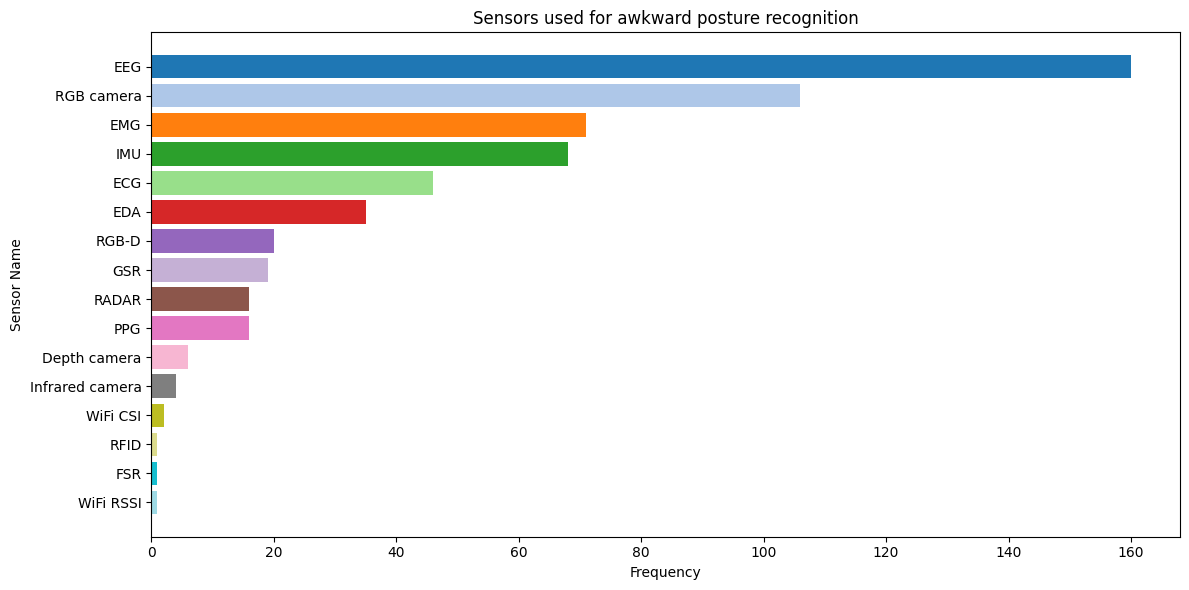

In [ ]:
sensors = [sensor for sensor, count in sensor_counterLLM.most_common()]
counts = [count for sensor, count in sensor_counterLLM.most_common()]


colors = plt.cm.get_cmap("tab20", len(sensors))

plt.figure(figsize=(12, 6))
plt.barh(sensors, counts, color=colors(range(len(sensors))))
plt.xlabel('Frequency')
plt.ylabel('Sensor Name')
plt.title('Sensors used for awkward posture recognition')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<ipython-input-17-cfec5f302fbf>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(sensors))


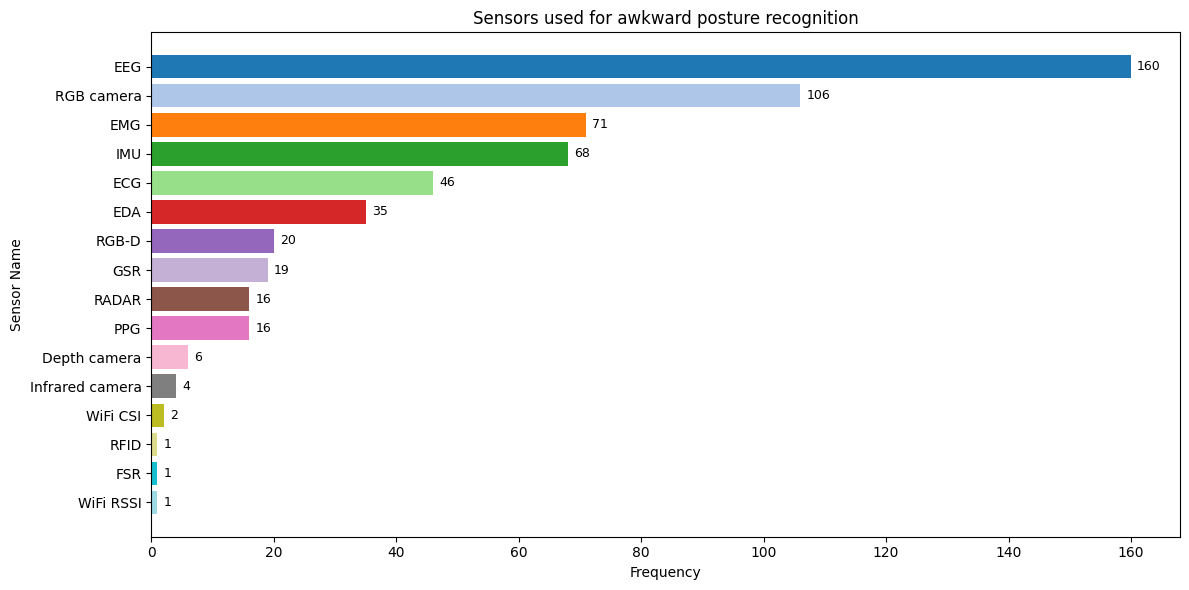

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

sensors = [sensor for sensor, count in sensor_counterLLM.most_common()]
counts = [count for sensor, count in sensor_counterLLM.most_common()]

colors = plt.cm.get_cmap("tab20", len(sensors))

plt.figure(figsize=(12, 6))
bars = plt.barh(sensors, counts, color=colors(range(len(sensors))))
plt.xlabel('Frequency')
plt.ylabel('Sensor Name')
plt.title('Sensors used for awkward posture recognition')
plt.gca().invert_yaxis()
plt.tight_layout()

# Add count labels next to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             str(int(width)),
             va='center', fontsize=9, color='black')

# Save the plot as a PNG
plot_filename = "sensor_usage_plot.png"
plt.savefig(plot_filename, dpi=600)

# Show the plot
plt.show()

# Download the image
files.download(plot_filename)
